In [1]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer

In [2]:
batch_size = 32
learning_rate = 2e-4
weight_decay = 1e-2
labels_count = 10
num_epochs = 100
fuzzy_dim = 5
fuzzy_rules_count = 100

prefix = "mamdani_mnist"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [4]:
def get_target(target_label):
    """
    Возвращает вектор целевого значения

    Args:
        target_label (int): Метка класса
    
    Returns:
        tensor (1, 10)
    """
    t = F.one_hot(torch.LongTensor([target_label]), labels_count)
    return t.to(device)

In [5]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target(x))
)

In [6]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target(x))
)
len(test_data)

10000

In [7]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [8]:
class Encoder(nn.Module):
    """
    Компонент энкодера
    
    Args:
        fuzzy_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, fuzzy_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, fuzzy_dim),
        )
         
    def forward(self, x):
        """
        Выход энкодера
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            encoded input
        """

        ex = self.encoder(x)
        
        return ex

In [9]:
class MamdaniFIS(nn.Module):
    """
    MamdaniFIS
    
    Args:
        fuzzy_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, fuzzy_dim, fuzzy_rules_count, labels_count):
        super(MamdaniFIS, self).__init__()

        self.encoder = Encoder(fuzzy_dim)        
        
        self.fuzzy = nn.Sequential(
            FuzzyLayer.from_dimensions(fuzzy_dim, fuzzy_rules_count, trainable=True),
            #nn.Softmax(1),
            #nn.Linear(fuzzy_rules_count, labels_count, bias=False)
            DefuzzyLinearLayer.from_dimensions(fuzzy_rules_count, labels_count)
        )
        
    def forward(self, x):
        """
        
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            labels
        """

        ex = self.encoder(x)
        labels = self.fuzzy(ex)

        return labels

In [10]:
def compute_loss(target_labels, predicted_labels):

    ceLoss = nn.CrossEntropyLoss(reduction="sum")
    
    loss_fuzzy = ceLoss.forward(predicted_labels, torch.squeeze(target_labels,1).float())

    return loss_fuzzy
    

In [11]:
model = MamdaniFIS(fuzzy_dim, fuzzy_rules_count, labels_count).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 5,836,653


MamdaniFIS(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=5, bias=True)
    )
  )
  (fuzzy): Sequential(
    (0): FuzzyLayer()
    (1): DefuzzyLinearLayer()
  )
)

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [13]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        labels = model.forward(data)  
        
        loss = compute_loss(target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            #print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [14]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            
            labels = model.forward(data)  
            
            loss = compute_loss(target, labels)
            
            test_loss += loss.item()
            
            pred_target = np.argmax(labels.cpu().numpy(), axis=1)
            target_labels =  np.argmax(torch.squeeze(target,1).cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)

In [15]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 46.7767 (Accuracy 0.6761)
Epoch 2/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 37.4924 (Accuracy 0.6818)
Epoch 3/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 30.8662 (Accuracy 0.6981)
Epoch 4/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 26.4151 (Accuracy 0.6944)
Epoch 5/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 22.6212 (Accuracy 0.7019)
Epoch 6/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 20.2460 (Accuracy 0.7001)
Epoch 7/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 18.5482 (Accuracy 0.6992)
Epoch 8/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 17.4906 (Accuracy 0.6999)
Epoch 9/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 16.6830 (Accuracy 0.7011)
Epoch 10/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 16.1412 (Accuracy 0.7015)
Epoch 11/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 15.4692 (Accuracy 0.7020)
Epoch 12/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 15.2409 (Accuracy 0.7022)
Epoch 13/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 15.1047 (Accuracy 0.7029)
Epoch 14/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 15.0628 (Accuracy 0.7036)
Epoch 15/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 13.8191 (Accuracy 0.7913)
Epoch 16/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 12.3809 (Accuracy 0.8908)
Epoch 17/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 10.7047 (Accuracy 0.8941)
Epoch 18/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 9.4418 (Accuracy 0.8922)
Epoch 19/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 7.1278 (Accuracy 0.9891)
Epoch 20/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 5.3836 (Accuracy 0.9891)
Epoch 21/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 3.9499 (Accuracy 0.9906)
Epoch 22/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 3.0699 (Accuracy 0.9903)
Epoch 23/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.4512 (Accuracy 0.9914)
Epoch 24/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.0409 (Accuracy 0.9916)
Epoch 25/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.0268 (Accuracy 0.9904)
Epoch 26/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1045 (Accuracy 0.9903)
Epoch 27/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 1.9865 (Accuracy 0.9903)
Epoch 28/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1144 (Accuracy 0.9892)
Epoch 29/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1511 (Accuracy 0.9903)
Epoch 30/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.0330 (Accuracy 0.9892)
Epoch 31/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 1.7489 (Accuracy 0.9913)
Epoch 32/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 1.9963 (Accuracy 0.9901)
Epoch 33/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.2757 (Accuracy 0.9881)
Epoch 34/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1119 (Accuracy 0.9896)
Epoch 35/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.0303 (Accuracy 0.9901)
Epoch 36/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 1.8714 (Accuracy 0.9912)
Epoch 37/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 1.8847 (Accuracy 0.9913)
Epoch 38/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1640 (Accuracy 0.9899)
Epoch 39/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3442 (Accuracy 0.9895)
Epoch 40/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 1.9997 (Accuracy 0.9907)
Epoch 41/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 1.8235 (Accuracy 0.9910)
Epoch 42/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.0377 (Accuracy 0.9906)
Epoch 43/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.2965 (Accuracy 0.9898)
Epoch 44/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1356 (Accuracy 0.9901)
Epoch 45/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1522 (Accuracy 0.9902)
Epoch 46/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.0477 (Accuracy 0.9916)
Epoch 47/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1878 (Accuracy 0.9906)
Epoch 48/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3323 (Accuracy 0.9899)
Epoch 49/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1782 (Accuracy 0.9900)
Epoch 50/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 1.8168 (Accuracy 0.9918)
Epoch 51/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1437 (Accuracy 0.9902)
Epoch 52/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3522 (Accuracy 0.9897)
Epoch 53/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.2261 (Accuracy 0.9910)
Epoch 54/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.6683 (Accuracy 0.9892)
Epoch 55/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.2466 (Accuracy 0.9896)
Epoch 56/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1980 (Accuracy 0.9906)
Epoch 57/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.0910 (Accuracy 0.9903)
Epoch 58/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3247 (Accuracy 0.9899)
Epoch 59/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3981 (Accuracy 0.9901)
Epoch 60/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3236 (Accuracy 0.9897)
Epoch 61/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1949 (Accuracy 0.9905)
Epoch 62/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1221 (Accuracy 0.9906)
Epoch 63/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3011 (Accuracy 0.9911)
Epoch 64/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.4565 (Accuracy 0.9900)
Epoch 65/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3420 (Accuracy 0.9903)
Epoch 66/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.2755 (Accuracy 0.9908)
Epoch 67/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.0471 (Accuracy 0.9918)
Epoch 68/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 1.9110 (Accuracy 0.9922)
Epoch 69/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3113 (Accuracy 0.9910)
Epoch 70/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.5766 (Accuracy 0.9896)
Epoch 71/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3698 (Accuracy 0.9906)
Epoch 72/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.4170 (Accuracy 0.9912)
Epoch 73/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.4957 (Accuracy 0.9892)
Epoch 74/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3025 (Accuracy 0.9908)
Epoch 75/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.5807 (Accuracy 0.9897)
Epoch 76/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.5672 (Accuracy 0.9904)
Epoch 77/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1070 (Accuracy 0.9914)
Epoch 78/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3226 (Accuracy 0.9910)
Epoch 79/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.6329 (Accuracy 0.9900)
Epoch 80/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.6958 (Accuracy 0.9901)
Epoch 81/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.2476 (Accuracy 0.9905)
Epoch 82/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1618 (Accuracy 0.9908)
Epoch 83/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3973 (Accuracy 0.9898)
Epoch 84/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3253 (Accuracy 0.9902)
Epoch 85/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1179 (Accuracy 0.9918)
Epoch 86/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.4179 (Accuracy 0.9900)
Epoch 87/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3807 (Accuracy 0.9911)
Epoch 88/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3549 (Accuracy 0.9908)
Epoch 89/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3877 (Accuracy 0.9907)
Epoch 90/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 1.9464 (Accuracy 0.9924)
Epoch 91/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1658 (Accuracy 0.9914)
Epoch 92/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.0770 (Accuracy 0.9914)
Epoch 93/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1091 (Accuracy 0.9913)
Epoch 94/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.0274 (Accuracy 0.9919)
Epoch 95/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.2935 (Accuracy 0.9909)
Epoch 96/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.0691 (Accuracy 0.9909)
Epoch 97/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.1807 (Accuracy 0.9910)
Epoch 98/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.3291 (Accuracy 0.9914)
Epoch 99/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.0893 (Accuracy 0.9919)
Epoch 100/100


  0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

====> Test set loss: 2.2332 (Accuracy 0.9919)


In [16]:
# encode and plot the z values for the train set 
model.eval()
features2d = []
labels_predicted = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        ft = model.encoder.forward(data)
        labs = model.forward(data)
        features2d.append(ft.cpu().numpy())
        labels_predicted.append(np.argmax(labs.cpu().numpy(), axis=1))
        labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))

features2d = np.concatenate(features2d, axis=0)
labels_predicted = np.concatenate(labels_predicted, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
        

Encoding:   0%|          | 0/313 [00:00<?, ?it/s]

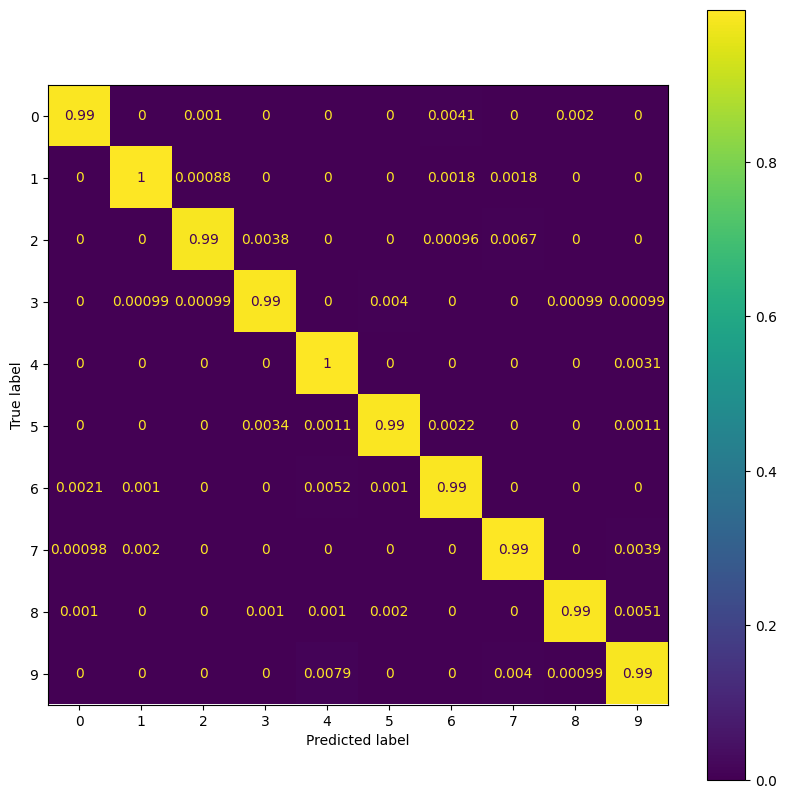

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels_predicted, labels_expected, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)

Text(0, 0.5, 'feature 2')

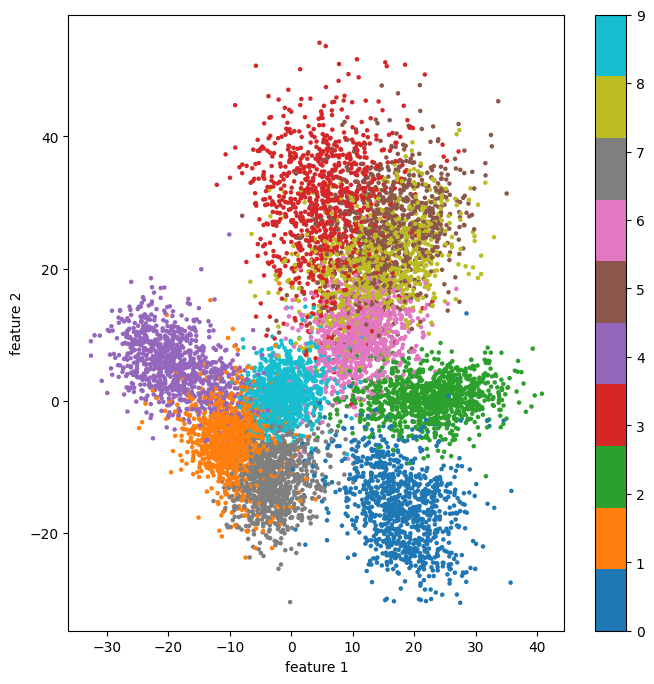

In [18]:
plt.figure(figsize=(8, 8))
plt.scatter(features2d[:, 0], features2d[:, 1], c=labels_expected, cmap='tab10', s=5)
plt.colorbar()
plt.xlabel("feature 1")
plt.ylabel("feature 2")